In [17]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Alphabet import IUPAC
from Bio.SeqRecord import SeqRecord
from Bio import SeqUtils
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFECV
import scikitplot as skplt
from sklearn import metrics

Features selected so far
Transition Probabilities: ['T to G', 'G to A', 'T to T', 'T to C', 'G to T', 'A to C']
Length categories: 
Upto window4: ['ATCA', 'ATC', 'ATCT', 'TATC', 'GATC', 'TCAG', 'TGGT', 'CGT', 'GCGT', 'CAGA', 'TCA', 'TCAT']
Window5: ['AGATC', 'GGATC', 'GCGTT', 'GATCA', 'ACGTG', 'ATCAG', 'GATCT', 'ATCAT',
       'CGCGT', 'ATCTC', 'ATATC', 'GTGGT', 'TCAGA', 'TGGTT', 'GCGTA', 'CACGT',
       'TCATC', 'AGCGT', 'CGCTT', 'CGTGT']
ORF counts: ['orfc ml200']

In [12]:
df1 = pd.read_csv('pndf.csv').drop(columns = ['Org', 'MolTyp', 'Topol', 'Des', 'Seq'])
df2 = pd.read_csv('pndf lenc tp.csv')[['T to G', 'G to A', 'T to T', 'T to C', 'G to T', 'A to C']].copy()
df3 = pd.read_csv('res 340.csv')[['ATCA', 'ATC', 'ATCT', 'TATC', 'GATC', 'TCAG', 
                                  'TGGT', 'CGT', 'GCGT', 'CAGA', 'TCA', 'TCAT']].copy()
df4 = pd.read_csv('../win5 len scaled.csv')[['AGATC', 'GGATC', 'GCGTT', 'GATCA', 'ACGTG', 'ATCAG', 'GATCT', 'ATCAT',
       'CGCGT', 'ATCTC', 'ATATC', 'GTGGT', 'TCAGA', 'TGGTT', 'GCGTA', 'CACGT',
       'TCATC', 'AGCGT', 'CGCTT', 'CGTGT']].copy()
df5 = pd.read_csv('Id orfc.csv')[['orfc ml200']].copy()
df = pd.concat([df1,df2,df3,df4,df5], axis = 1, copy = False)

df.loc[df['Gen'] == 'ssRNA(+)', 'Gen'] = 0
df.loc[df['Gen'] == 'ssRNA(-)', 'Gen'] = 1

In [22]:
def rf(data, split, nest, crt, cvf):
    #Splitting features and labels
    X = data.iloc[:, 2:].values.astype(float)
    y = data.iloc[:, 1].values.astype(float)
    
    # Splitting the dataset into the Training set and Test set
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = split)
    
    # Feature Scaling
    from sklearn.preprocessing import StandardScaler
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    
    # Fitting Random Forest Classification to the Training set
    from sklearn.ensemble import RandomForestClassifier
    classifier = RandomForestClassifier(n_estimators = nest, criterion = crt)
    classifier.fit(X_train, y_train)
    
    # Predicting the Test set results
    y_pred = classifier.predict(X_test)
    
    # Making the Confusion Matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, y_pred)
    
    cv_bin = cross_val_score(classifier, X, y, cv=cvf, scoring='f1')
    cv_mac = cross_val_score(classifier, X, y, cv=cvf, scoring='f1_macro')
    f1bin = f1_score(y_test, y_pred, average='binary')
    f1mac = f1_score(y_test, y_pred, average='macro')
    
    
    dunnowhat = metrics.accuracy_score(y_test, y_pred)
    y_pred_proba = classifier.predict_proba(X_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()

#     #feature selection 1
#     selector1 = SelectFromModel(RandomForestClassifier(n_estimators = 150))
#     selector1.fit(X_train, y_train)
#     #feature selection 2
#     selector2 = RFECV(RandomForestClassifier(n_estimators = 150), step=1, cv=5)
#     selector2 = selector2.fit(X_train, y_train)
    
#     return (selector1.get_support()), (selector2.get_support())
    
    return cv_bin, cv_mac, f1bin, dunnowhat

In [84]:
a,b = rf(df, 0.25, 150, 'entropy', 5)

In [85]:
df.iloc[:,2:].columns[~b]

Index([], dtype='object')

In [86]:
df.iloc[:,2:].columns[~a]

Index(['T to G', 'G to A', 'T to T', 'T to C', 'G to T', 'A to C', 'TATC',
       'TCAG', 'TGGT', 'CGT', 'GCGT', 'CAGA', 'TCAT', 'GGATC', 'GCGTT',
       'ACGTG', 'GATCT', 'CGCGT', 'ATCTC', 'GTGGT', 'TCAGA', 'TGGTT', 'GCGTA',
       'CACGT', 'TCATC', 'AGCGT', 'CGCTT', 'CGTGT'],
      dtype='object')

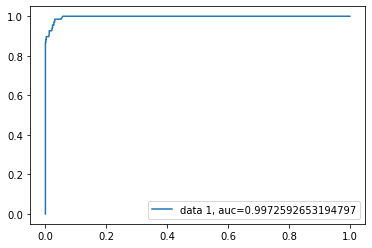

0.9276824919445049 0.04493849223742054 0.9605174984184984 0.022871875017139075 0.9218749999999999 0.9872935196950444


In [23]:
cv_bin, cv_mac, f1bin, f1mac = rf(df, 0.25, 250, 'entropy', 5)

print(cv_bin.mean(), cv_bin.std(), cv_mac.mean(), cv_mac.std(), f1bin, f1mac)

In [92]:
cv_bin, cv_mac, f1bin, f1mac = rf(df, 0.25, 150, 'entropy', 5)

print(cv_bin.mean(), cv_bin.std(), cv_mac.mean(), cv_mac.std(), f1bin, f1mac)

0.9168011409857175 0.05429153763125063 0.9576400565161756 0.023630328422923095 1.0 1.0
